# Capability Correlations and Time

In the second part of the analysis we will focus on how the global capabilities change with time. This part looks to answer one main question that can be divided into other severall research questions. 
- How does the research and innovation in a certain field change over time? 
- Are there any chronological gaps in the research throughout the years? 
[...]

### Table of Contents
[//]: # (- [1. Database Matrix of Occurences](#one))
[//]: # (  - [1.1. Getting the data from Neo4j](#one-one))
[//]: # (  - [1.2. Designing the queries](#one-two)    )
[//]: # (  - [1.3. The first part of the matrix: No intersections.](#one-three))
[//]: # (  - [1.4. The second part of the matrix: Intersections.](#one-four))
[//]: # (  - [1.5. Testing the co-occurence matrix](#one-five))
[//]: # (  - [1.6. Printing the matrix](#one-six))
[//]: # (- [2. Co-occurence by country](#two))
[//]: # (  - [2.1. Co-ocurence matrixes for countries](#two-one))
[//]: # (  - [2.2. Transforming the co-occurence matrix into a list](#two-two))
[//]: # (  - [2.3. Visualizing correlations](#two-three))
[//]: # (  - [2.4. Creating a correlation matrix](#two-four))
[//]: # (    - [2.4.1. Regular Matrix](#two-four-one))
[//]: # (    - [2.4.2. Reordered Matrix: Clustermap](#two-four-two))
[//]: # (  - [2.5. Country profiles](#two-five))
[//]: # (- [3. Contextual Relations](#three))

## 1. Data Extraction

Let's start by importing all of the external libraries that will be useful during the analysis. 

In [27]:
from py2neo import Graph
import numpy as np 
from pandas import DataFrame
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import pandas as pd
import plotly 
import plotly.graph_objs as go
import qgrid
from scipy import stats, spatial
from sklearn.cluster.bicluster import SpectralBiclustering
import operator

# connection to Neo4j
local_connection_url = "http://localhost:7474/db/data"
connection_to_graph = Graph(local_connection_url)

# plotly credentials
plotly_config = json.load(open('plotly_config.json'))
plotly.tools.set_credentials_file(username=plotly_config['username'], api_key=plotly_config['key'])

### 1.1. The Years

Not all years in the Neo4j databse contain technological assets. For this reason, two lists will be created. A completely chronological one and a database one. 

In [28]:
# query years
years_available_q = """     MATCH (n:Asset)
                            WITH n.year as YEAR
                            RETURN YEAR, count(YEAR)
                            ORDER BY YEAR ASC """

# create a list with the years where records exist
years_available = DataFrame(connection_to_graph.data(years_available_q)).as_matrix()[:, 0][:-1]
years_available = [int(year) for year in years_available]

# create a pure range list
first_year = int(years_available[0])
last_year = int(years_available[-1])
real_years = range(first_year, last_year + 1, 1)

# give information 
print 'The database list starts in {}, ends in {} and contains {} years.'.format(years_available[0], years_available[-1], len(years_available))
print 'The real list starts in {}, ends in {} and contains {} years.'.format(real_years[0], real_years[-1], len(real_years))

The database list starts in 1938, ends in 2019 and contains 38 years.
The real list starts in 1938, ends in 2019 and contains 82 years.


Now that we have all of the years available, we can start building the technological capability matrixes, with a similar process to what was previsouly done. 

### 1.2. Co-occurence matrix for the years

#### 1.2.1. Getting the labels

We start by importing a few methods from the previous notebook. 

In [29]:
def find_index(something, in_list):
    return in_list.index(something)

Let's first get all of the axis that our matrixes will take.

We start by designing two queries that will help us get all of the labels of the matrix. 

The labels of the non intersecting part: 

In [30]:
q_noInter_axis = """    MATCH (a:Asset)-[:CONTAINS]->(fs:Feedstock)
                        MATCH (a:Asset)-[:CONTAINS]->(out:Output)
                        MATCH (a:Asset)-[:CONTAINS]->(pt:ProcessingTech)
                        RETURN fs.term, pt.term, out.term, count(a)
                                """

feedstocks = np.unique(DataFrame(connection_to_graph.data(q_noInter_axis)).as_matrix()[:, 1]).tolist()
proc_tech = np.unique(DataFrame(connection_to_graph.data(q_noInter_axis)).as_matrix()[:, 2]).tolist()
output = np.unique(DataFrame(connection_to_graph.data(q_noInter_axis)).as_matrix()[:, 3]).tolist()

axis_names = feedstocks + proc_tech + output 
print 'The axis list has {} terms.'.format(len(axis_names))

The axis list has 289 terms.


The labels of the intersecting part:

In [31]:
q_Inter_axis = """  MATCH (a:Asset)-[:CONTAINS]->(fs:{})
                    MATCH (a:Asset)-[:CONTAINS]->(t:{})
                    WHERE fs<>t 
                    RETURN fs.term, t.term, count(a)
                                    """
process_variables = ['Feedstock', 'Output', 'ProcessingTech']

# Extra labels that only appear in non-intersection queries
for category in process_variables:
    data_no_intersections = DataFrame(connection_to_graph.data(q_Inter_axis.format(category, category))).as_matrix()
    for column_number in range(1,3):
        column = data_no_intersections[:, column_number]
        for name in column:
            if name not in axis_names:
                axis_names.append(name)

print 'The axis list has {} terms.'.format(len(axis_names))                

The axis list has 342 terms.


#### 1.2.2. Function

We start by creating a function that given a certain year, returns the year's capability matrix. 

In [32]:
def get_year_matrix(year, normalization=True):
    
    # define queries
    q1 = """   MATCH (a:Asset)-[:CONTAINS]->(fs:Feedstock)
                MATCH (a:Asset)-[:CONTAINS]->(out:Output)
                MATCH (a:Asset)-[:CONTAINS]->(pt:ProcessingTech)
                WHERE a.year = "{}"
                RETURN fs.term, pt.term, out.term, count(a)
                                    """.format(year)
    
    process_variables = ['Feedstock', 'Output', 'ProcessingTech']
    
    q2 = """   MATCH (a:Asset)-[:CONTAINS]->(fs:{})
                MATCH (a:Asset)-[:CONTAINS]->(t:{})
                WHERE fs<>t AND a.year = "{}"
                RETURN fs.term, t.term, count(a)
                                    """
    # get data
    data_q1 = DataFrame(connection_to_graph.data(q1)).as_matrix()
    
    # create matrix
    year_matrix = np.zeros([len(axis_names), len(axis_names)])
    
    # for no intersections data
    for row in data_q1:
        # the last column is the frequency (count)
        frequency = row[0]
        indexes = [find_index(element, axis_names) for element in row[1::]]
        # add frequency value to matrix position not inter
        for pair in itertools.combinations(indexes, 2):
            year_matrix[pair[0], pair[1]] += frequency
            year_matrix[pair[1], pair[0]] += frequency
    
    # for intersecting data
    for category in process_variables:
        process_data = DataFrame(connection_to_graph.data(q2.format(category, category, year))).as_matrix()
        for row in process_data:
            frequency = row[0]
            indexes = [find_index(element, axis_names) for element in row[1::]]
            # add frequency value to matrix position inter
            for pair in itertools.combinations(indexes, 2):
                year_matrix[pair[0], pair[1]] += frequency / 2 # Divided by two because query not optimized
                year_matrix[pair[1], pair[0]] += frequency / 2 # Divided by two because query not optimized
    
    # normalize
    norm_year_matrix = (year_matrix - np.mean(year_matrix)) / np.std(year_matrix)
    
    # dynamic return 
    if normalization == True:
        return norm_year_matrix
    else: 
        return year_matrix

We finally test our function with the year 2016. 

In [33]:
year = 2016
print 'The matrix from {} has shape {} a max value of {}, a min value of {} and a mean of {}.'.format(year, get_year_matrix(year).shape, np.amax(get_year_matrix(year)), np.amin(get_year_matrix(year)), np.mean(get_year_matrix(year)))

The matrix from 2016 has shape (342, 342) a max value of 94.0056982009, a min value of -0.0794170079582 and a mean of 1.02058051715e-17.


## 2. Analysis

In order to analyse the correlation of the years between themselves, we will need to transform each year matrix into a list. Since the matrix is symmetrical, we will only need the upper triangle. For programming reasons, we have designed our own upper triangulization matrix. 

In [34]:
def get_list_from(matrix):
    only_valuable = []
    extension = 1
    for row_number in range(matrix.shape[0]):
        only_valuable.append(matrix[row_number, extension:matrix.shape[0]].tolist()) # numpy functions keep 0s so I hard coded it. 
        extension += 1 
    return [element for column in only_valuable for element in column ]

### 2.1. Year Profiles

Let's visualize the correlation between two years and their capability arrays. 

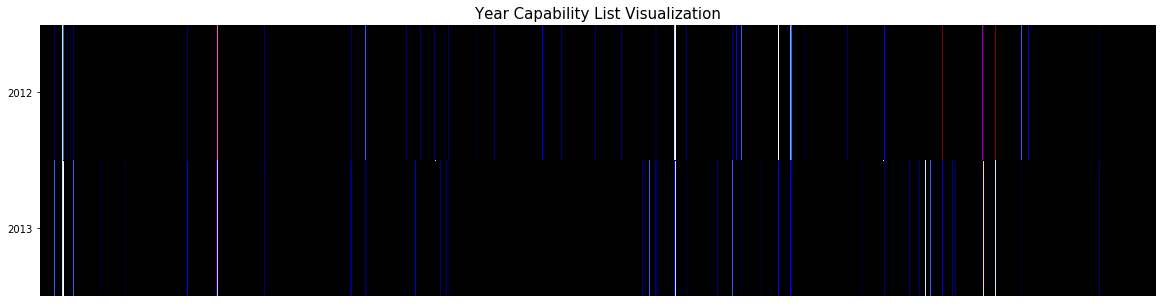

The pearson correlation index between the two years is: 0.902580296089 (P-value of 0.0)


In [35]:
# apply functions to both countries
a_list = get_list_from(get_year_matrix(2012, normalization=True))
b_list = get_list_from(get_year_matrix(2013, normalization=True))

# create a matrix where each row is a list of a country
corelation = np.vstack((a_list, b_list))

# plot the matrix 
plt.subplots(1,1,figsize=(20, 5))
plt.subplot(111)
sns.heatmap(corelation, cmap='flag_r', cbar=None, square=False, yticklabels=['2012', '2013'], xticklabels=False)
plt.yticks(rotation=0)
plt.title('Year Capability List Visualization', size=15)
plt.show()

print 'The pearson correlation index between the two years is: {} (P-value of {})'.format(stats.pearsonr(a_list, b_list)[0], stats.pearsonr(a_list, b_list)[1])

It is already apparent that these two consecutive years are highly correlated.

### 2.2. Correlation Matrix

#### 2.2.1. Considerations

As previously done with countries, a year correlation matrix will be built. 

We first define the scope of the matrix.

In [36]:
number_of_years = len(years_available)
years_in_matrix = years_available
years_correlation = np.zeros([number_of_years, number_of_years])
print years_in_matrix

[1938, 1975, 1980, 1981, 1983, 1985, 1986, 1988, 1989, 1990, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]


And we build the matrix

In [37]:
data = np.load('Data/year_capability_dict.npy').item()
for row in range(number_of_years):
    print 'Processing year {} / {} ({})\r'.format(row + 1, number_of_years, years_in_matrix[row]),
    year_1_list = data[years_in_matrix[row]]
    for column in range(number_of_years):
        
        year_2_list = data[years_in_matrix[column]]

        years_correlation[row, column] = stats.pearsonr(year_1_list, year_2_list)[0]
        

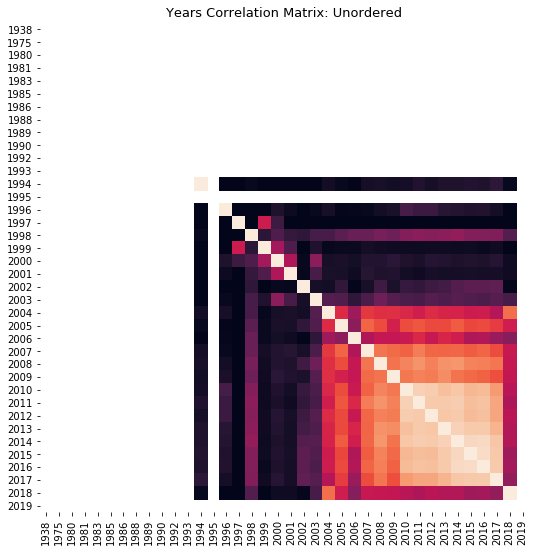

In [38]:
plt.subplots(1,1,figsize=(9, 9))
plt.subplot(111)
sns.heatmap(years_correlation, cbar=False, square=True, yticklabels=years_in_matrix, xticklabels=years_in_matrix)
plt.title('Years Correlation Matrix: Unordered', size=13)
plt.show()

There seems to be a lot of data missing. 

Let's plot the amount of records in our databse over time to get a better sense on how to approach the problem.

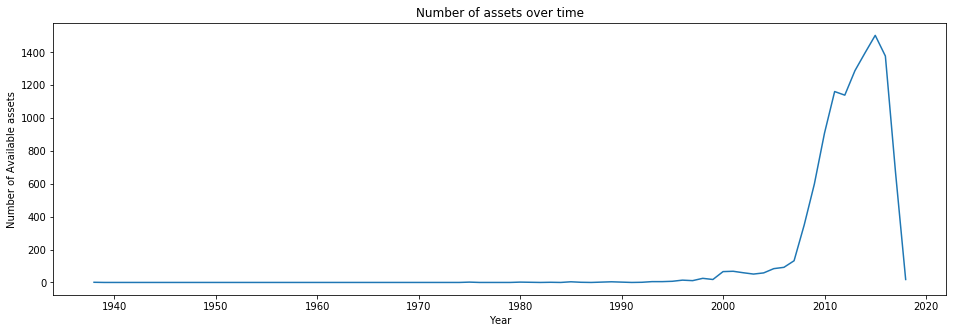

In [39]:
# get all of the data
data = DataFrame(connection_to_graph.data(years_available_q)).as_matrix()
raw = [int(a) for a in data[:-1, 0]]
timeline = range(min(raw), max(raw))
qtties = []

# build a timeline and number of records. 
for year in timeline:
    if year not in raw:
        qtties.append(0)
    else: 
        idx = find_index(str(year), list(data[:, 0]))
        qtties.append(data[idx, 1])

# plot the graph
plt.subplots(1,1,figsize=(16, 5))
plt.subplot(111)
plt.title("Number of assets over time")
plt.xlabel("Year")
plt.ylabel("Number of Available assets")
plt.plot(timeline, qtties)
plt.show()

#### 2.2.2. Final co-ocurrence matrix

To counteract the fact that our dataset is not uniformily distributed across the years, we will only consider the last 15 years. [2004-2018]

In [40]:
number_of_years = 15
years_in_matrix = years_available[:-1][-number_of_years:]
years_correlation = np.zeros([number_of_years, number_of_years])

We now rebuild and plot the heatmaop of correlations. 

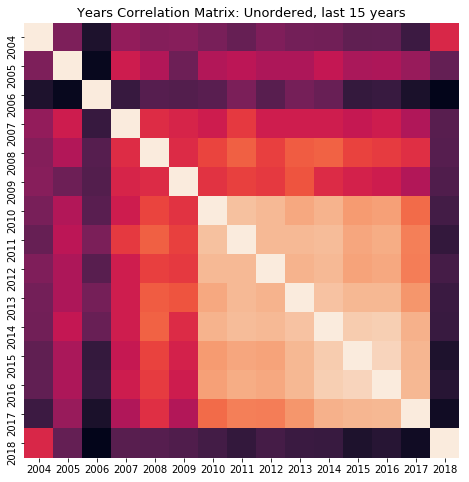

In [41]:
data = np.load('Data/year_capability_dict.npy').item()
for row in range(number_of_years):
    print 'Processing year {} / {} ({})\r'.format(row + 1, number_of_years, years_in_matrix[row]),
    year_1_list = data[years_in_matrix[row]]
    for column in range(number_of_years):        
        year_2_list = data[years_in_matrix[column]]
        years_correlation[row, column] = stats.pearsonr(year_1_list, year_2_list)[0]

plt.subplots(1,1,figsize=(8, 8))
plt.subplot(111)
sns.heatmap(years_correlation, cbar=False, square=True, yticklabels=years_in_matrix, xticklabels=years_in_matrix)
plt.title('Years Correlation Matrix: Unordered, last 15 years', size=13)
plt.show()

#### 2.2.3. Heatmap Clustering

Let us reorder the heatmap according to hierarchical clustering. 

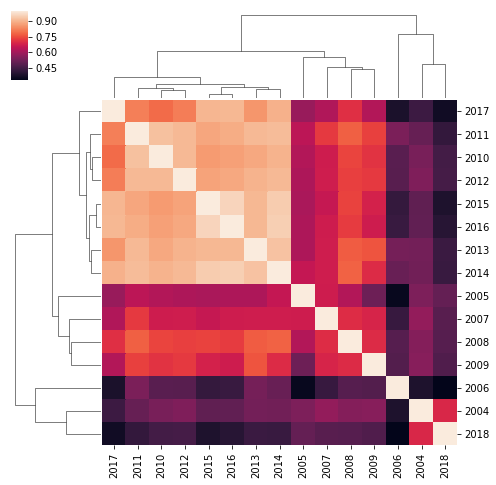

In [42]:
# plot the clustermap
a = sns.clustermap(years_correlation,  figsize=(8, 8), xticklabels = years_in_matrix, yticklabels=years_in_matrix)
plt.show()

### 2.3. Correlation Over Time

Let us see how related is each year in our matrx with the one before it. In this way we might more easily detect discripancies. 

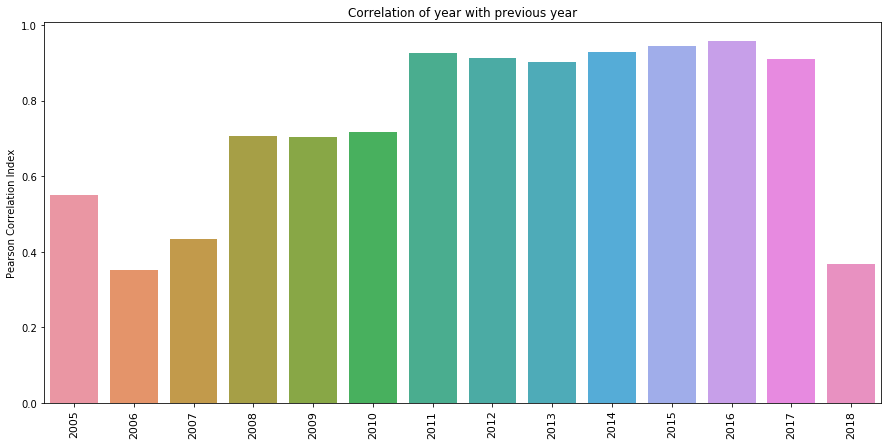

In [43]:
# remove first year
advanced_timeline = years_in_matrix[1::]
corr_with_pre = []

row = 1
col = 0
for year in advanced_timeline:
    corr_with_pre.append(years_correlation[row, col])
    row = row + 1
    col = col + 1

plt.subplots(1,1,figsize=(15,7))
sns.barplot(np.arange(len(corr_with_pre)), corr_with_pre )
plt.xticks(np.arange(len(corr_with_pre)), advanced_timeline, rotation=90, fontsize=11)
plt.title('Correlation of year with previous year')
plt.ylabel('Pearson Correlation Index')
plt.show()

Some years, such as 2006 or 2007 appear to have very low correlations with the years after. There seems to be an overall tendency of augmenting correlation with the years. 